# MPS using the deesseX wrapper

The principle of deesseX is to fill the simulation grid by successively simulating sections with deesse (according the the given orientation) conditionally to the sections previously simulated. The name deesseX refers to crossing-simulation / X-simulation with deesse.

## Example - 3D non-stationary simulation from 2D sections parallel to XZ and YZ planes...

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import time
import os

# import package 'geone'
import geone as gn

In [2]:
pv.set_jupyter_backend('static') # to get static plots within the jupyter notebook

## Training images
Read an image representing the geology of a fluvio-glacial aquifer in a vertical section. See reference: A. Comunian, P. Renard, J. Straubhaar, P. Bayer (2011) Three-dimensional high resolution fluvio-glacial aquifer analog: Part 2: geostatistical modeling. Journal of Hydrology 405(1-2), 10-23, [doi:10.1016/j.jhydrol.2011.03.037](https://dx.doi.org/10.1016/j.jhydrol.2011.03.037).

In [3]:
data_dir = 'data' # directory containing the training image file
im = gn.img.readImageGslib(os.path.join(data_dir, 'herten.gslib'))

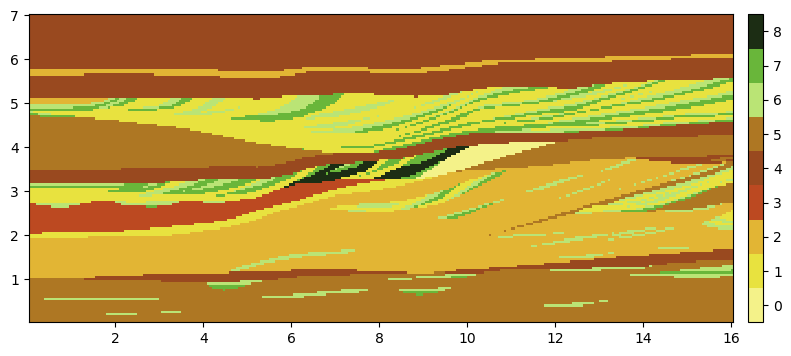

Image dimension: 320 x 1 x 140


In [4]:
# Value of the variable (facies)
categVal = im.get_unique()

# Color for facies in hexadecimal notation
categCol = [
    "#f4f289",
    "#e8e23f",
    "#e2b534",
    "#bc4921",
    "#99491f",
    "#ae7723",
    "#bae475",
    "#69b63a",
    "#1c2d14",
]

# Figure
plt.figure(figsize=(10,4))
gn.imgplot.drawImage2D(im, iy=0, categ=True, categCol=categCol)
plt.show()

print(f'Image dimension: {im.nx} x {im.ny} x {im.nz}')

### Prepare TIs for section parallel to XZ and YZ planes
Use the above images as reference for vertical sections (XZ and YZ orientations).

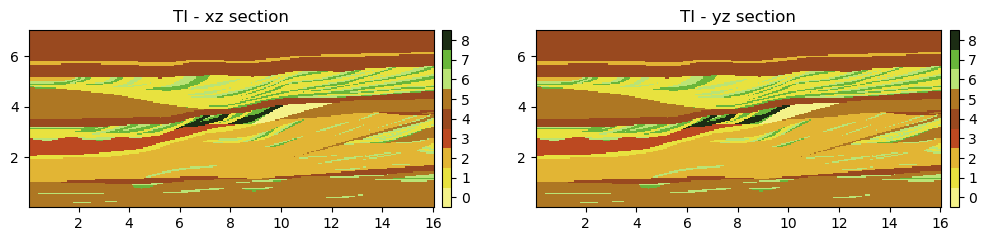

TI xz dimension: 320 x 1 x 140
TI yz dimension: 1 x 320 x 140
TI xz cell size: 0.05 x 0.05 x 0.05
TI yz cell size: 0.05 x 0.05 x 0.05


In [5]:
# TI for XZ section:
ti_xz = im # oriented in xz plane

# TI for YZ section:
ti_yz = gn.img.copyImg(ti_xz)
ti_yz.permxy() # permutes axes x and y

# Plot the TIs to be sure of their orientation in the desired plane. Check also the cell size.
plt.subplots(1,2, figsize=(12,4))

plt.subplot(1,2,1)
gn.imgplot.drawImage2D(ti_xz, iy=0, categ=True, categCol=categCol)
plt.title('TI - xz section')

plt.subplot(1,2,2)
gn.imgplot.drawImage2D(ti_yz, ix=0, categ=True, categCol=categCol)
plt.title('TI - yz section')

plt.show()

print(f'TI xz dimension: {ti_xz.nx} x {ti_xz.ny} x {ti_xz.nz}')
print(f'TI yz dimension: {ti_yz.nx} x {ti_yz.ny} x {ti_yz.nz}')

print(f'TI xz cell size: {ti_xz.sx} x {ti_xz.sy} x {ti_xz.sz}')
print(f'TI yz cell size: {ti_yz.sx} x {ti_yz.sy} x {ti_yz.sz}')

## Simulation without auxiliary variable
First, try to do deesseX simulation not accounting for the vertical trend (non-stationarity).

### Set up for deesseX

In [6]:
# sim grid 
nx, ny, nz = 150, 150, 140
sx, sy, sz = 1.0, 1.0, 1.0
ox, oy, oz = 0.0, 0.0, 0.0

# number of variables to be simulated, and their names
nv = 1
varname = im.varname
distanceType='categorical'

# Strategy of simulation
deesseX_input_section_path = gn.deesseinterface.DeesseXInputSectionPath(
    sectionMode='section_xz_yz',
    sectionPathMode='section_path_subdiv'
)

# Deesse parameters for ...
# ... section parallel to xz plane
deesseX_input_section_xz = gn.deesseinterface.DeesseXInputSection(
    nx=nx, ny=ny, nz=nz, nv=nv, # dimension of the simulation grid (number of cells), number of variable(s)
    distanceType=distanceType,  # distance type
    sectionType='xz',           # section type for which the deesse parameters are defined
    TI=ti_xz,                   # TI (class gn.deesseinterface.Img)
    nneighboringNode=48,        # max. number of neighbors (for the patterns)
    distanceThreshold=0.02,     # acceptation threshold (for distance between patterns)
    maxScanFraction=0.25,       # max. scanned fraction of the TI (for simulation of each cell)
    npostProcessingPathMax=1,   # number of post-processing path(s)
)

# ... section parallel to yz plane
deesseX_input_section_yz = gn.deesseinterface.DeesseXInputSection(
    nx=nx, ny=ny, nz=nz, nv=nv, # dimension of the simulation grid (number of cells), number of variable(s)
    distanceType=distanceType,  # distance type
    sectionType='yz',           # section type for which the deesse parameters are defined
    TI=ti_yz,                   # TI (class gn.deesseinterface.Img)
    nneighboringNode=48,        # max. number of neighbors (for the patterns)
    distanceThreshold=0.02,     # acceptation threshold (for distance between patterns)
    maxScanFraction=0.25,       # max. scanned fraction of the TI (for simulation of each cell)
    npostProcessingPathMax=1,   # number of post-processing path(s)
)

# Main input for deesseX
deesseX_input = gn.deesseinterface.DeesseXInput(
    nx=nx, ny=ny, nz=nz,        # dimension of the simulation grid (number of cells)
    sx=sx, sy=sy, sz=sz,        # cells units in the simulation grid (here are the default values)
    ox=ox, oy=oy, oz=oz,        # origin of the simulation grid (here are the default values)
    nv=nv, varname=varname,     # number of variable(s), name of the variable(s)
    distanceType=distanceType,  # distance type: proportion of mismatching nodes (categorical var., default)
    sectionPath_parameters=deesseX_input_section_path, 
                                # section path (defining the succession of section to be simulated)
                                # (class gn.deesseinterface.DeesseXInputSectionPath)
    section_parameters=[deesseX_input_section_xz, deesseX_input_section_yz],
                                # simulation parameters for each section type
                                # (sequence of class gn.deesseinterface.DeesseXInputSection)
    seed=333,                   # seed (initialization of the random number generator)
    nrealization=1)             # number of realization(s)

### Launching deesseX

In [7]:
# Run deesseX
t1 = time.time() # start time
deesseX_output = gn.deesseinterface.deesseXRun(deesseX_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

DeeSseX running... [VERSION 1.0 / BUILD NUMBER 20230411 / OpenMP 19 thread(s)]
* checking out license OK.
DeeSseX run complete
Elapsed time: 78 sec


### Retrieve the results (and display)

../src/intel/isl/isl.c:2216: FINISHME: ../src/intel/isl/isl.c:isl_surf_supports_ccs: CCS for 3D textures is disabled, but a workaround is available.


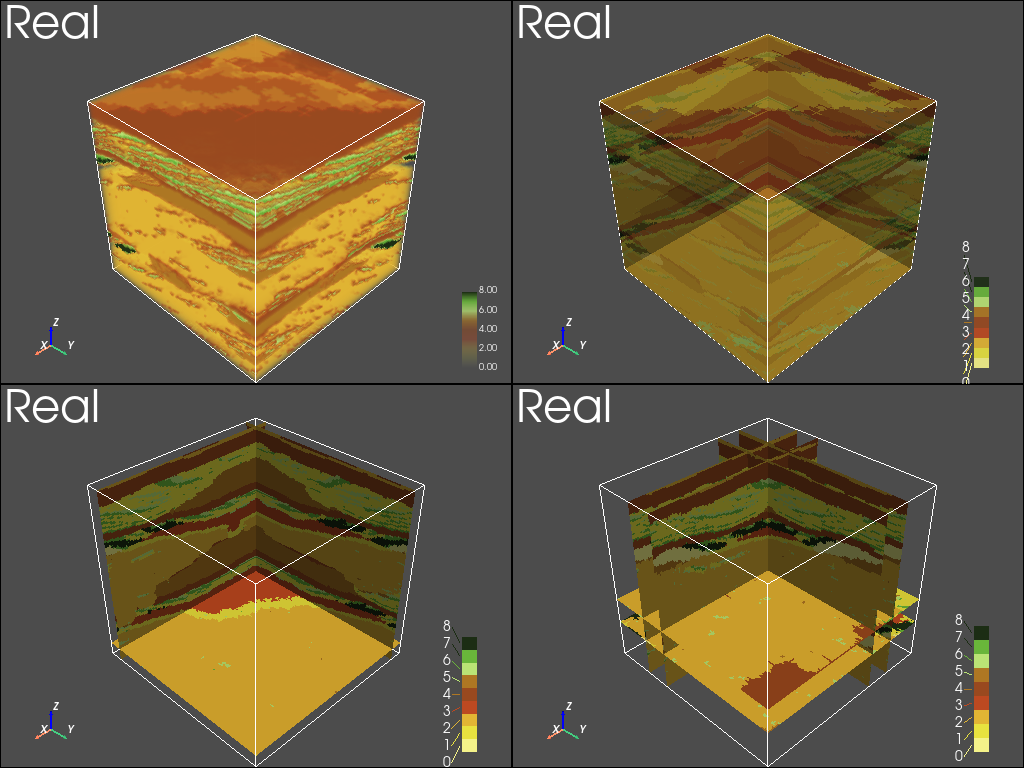

In [8]:
# Retrieve results
sim = deesseX_output['sim']

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

pp.subplot(0,0)
cmap = gn.customcolors.custom_cmap(categCol)
gn.imgplot3d.drawImage3D_volume(sim[0], plotter=pp,
    cmin=categVal[0],
    cmax=categVal[-1],
    cmap=cmap,
    scalar_bar_kwargs={'title':' ', 'vertical':True}, # distinct title in each subplot 
                                                      #    for correct display!
    text='Real')

pp.subplot(0,1)
gn.imgplot3d.drawImage3D_surface(sim[0], plotter=pp,
    categ=True,
    categVal=categVal,
    categCol=categCol,
    alpha=.9, # transparency (alpha channel)
    scalar_bar_kwargs={'title':'  ', 'vertical':True}, # distinct title in each subplot 
                                                       #    for correct display!
    text='Real')

pp.subplot(1,0)
gn.imgplot3d.drawImage3D_slice(sim[0], plotter=pp,
    slice_normal_x=[10], 
    slice_normal_y=[10],
    slice_normal_z=[10],
    categ=True,
    categVal=categVal,
    categCol=categCol,
    alpha=1.0, # transparency (alpha channel)
    scalar_bar_kwargs={'title':'   ', 'vertical':True}, # distinct title in each subplot 
                                                        #    for correct display!
    text='Real')

pp.subplot(1,1)
gn.imgplot3d.drawImage3D_slice(sim[0], plotter=pp,
    slice_normal_x=[30, 50], 
    slice_normal_y=[30, 50],
    slice_normal_z=[30, 50],
    categ=True,
    categVal=categVal,
    categCol=categCol,
    alpha=1.0, # transparency (alpha channel)
    scalar_bar_kwargs={'title':'    ', 'vertical':True}, # distinct title in each subplot 
                                                         #    for correct display!
    text='Real')

pp.link_views()
pp.show()

## Simulation with auxiliary variable
Add an auxiliary varibale to control the vertical trend (non-stationarity).

- For both TIs, insert an auxiliary variable named 'aux' at (variable) index 0, taken values from 0 to 1 (varying linearly) along the vertical. 
- For the simulation grid, define an auxiliary variable named 'aux' on the entire domain.

In [9]:
# Add aux variable for ti_xz
ti_xz.insert_var(val=np.repeat(np.linspace(0, 1, ti_xz.nz), ti_xz.nx), varname='aux', ind=0)

# Add aux variable for ti_yz
ti_yz.insert_var(val=np.repeat(np.linspace(0, 1, ti_yz.nz), ti_yz.ny), varname='aux', ind=0)

# Define aux variable on the entire simulation grid
nx, ny, nz = 150, 150, 140
sx, sy, sz = 1.0, 1.0, 1.0
ox, oy, oz = 0.0, 0.0, 0.0

sim_aux = gn.img.Img(
            nx=nx, ny=ny, nz=nz,
            sx=nx, sy=ny, sz=nz,
            ox=nx, oy=ny, oz=nz,
            nv=1, val=np.repeat(np.linspace(0, 1, nx*ny), nz), varname='aux')

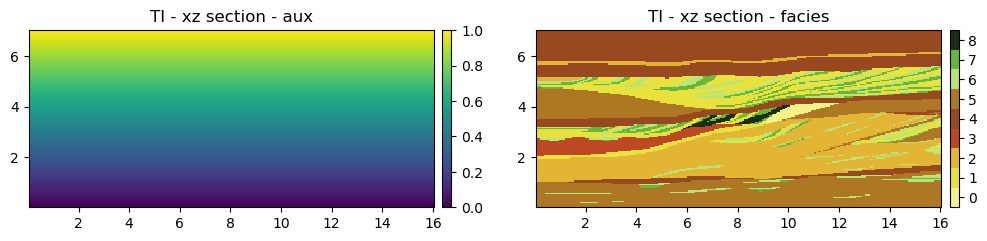

In [10]:
# Figure
plt.subplots(1,2, figsize=(12,4))

plt.subplot(1,2,1)
gn.imgplot.drawImage2D(ti_xz, iv=0, iy=0, cmap='viridis')
plt.title(f'TI - xz section - {ti_xz.varname[0]}')

plt.subplot(1,2,2)
gn.imgplot.drawImage2D(ti_xz, iv=1, iy=0, categ=True, categCol=categCol)
plt.title(f'TI - xz section - {ti_xz.varname[1]}')

plt.show()


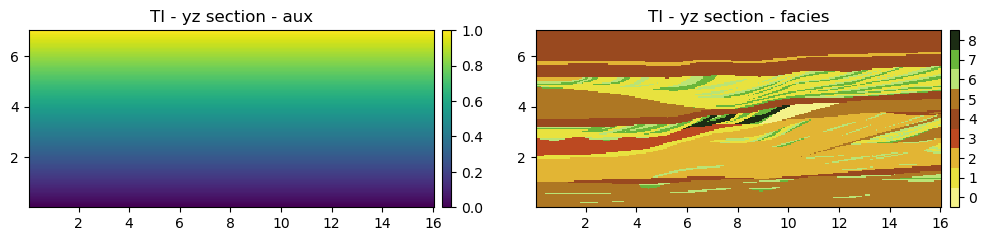

In [11]:
# Figure
plt.subplots(1,2, figsize=(12,4))

plt.subplot(1,2,1)
gn.imgplot.drawImage2D(ti_yz, iv=0, ix=0, cmap='viridis')
plt.title(f'TI - yz section - {ti_xz.varname[0]}')

plt.subplot(1,2,2)
gn.imgplot.drawImage2D(ti_yz, iv=1, ix=0, categ=True, categCol=categCol)
plt.title(f'TI - yz section - {ti_yz.varname[1]}')

plt.show()


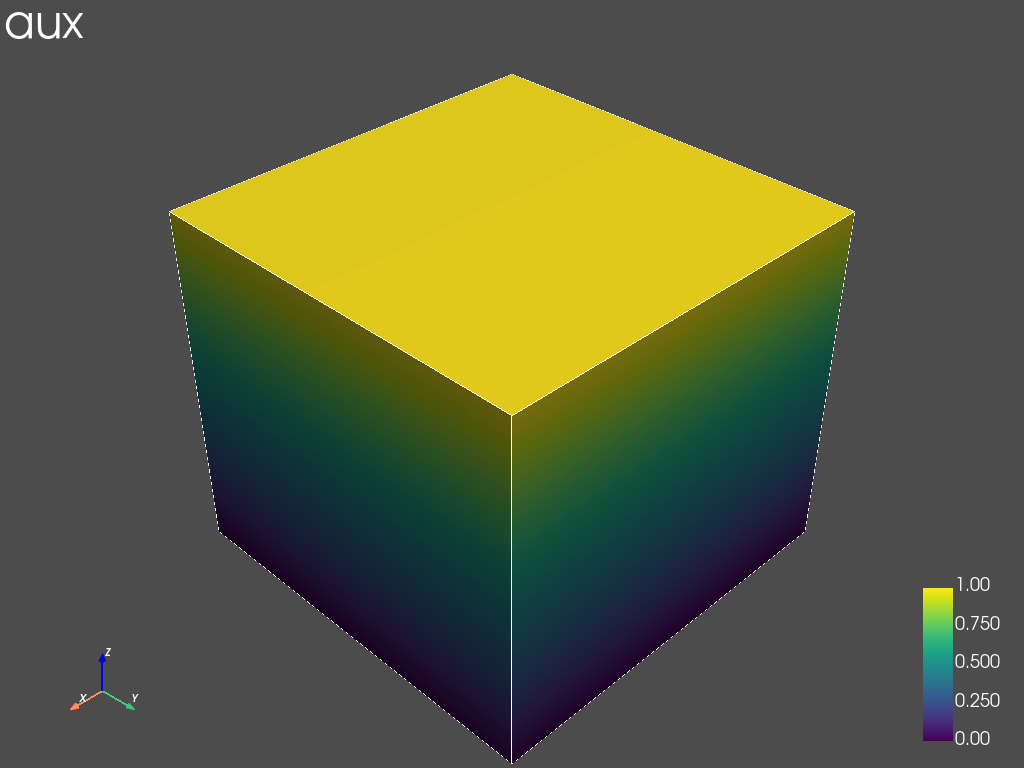

In [12]:
# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(notebook=False)
# ... inline
pp = pv.Plotter()

cmap = gn.customcolors.custom_cmap(categCol)
gn.imgplot3d.drawImage3D_surface(sim_aux, plotter=pp,
    cmap='viridis',
    scalar_bar_kwargs={'title':' ', 'vertical':True},
    text='aux')
pp.show()

### Set up for deesseX

In [13]:
# number of variables to be simulated, and their names
nv = 2
varname = ['aux', 'facies']
distanceType=['continuous', 'categorical']

# Strategy of simulation
deesseX_input_section_path = gn.deesseinterface.DeesseXInputSectionPath(
    sectionMode='section_xz_yz',
    sectionPathMode='section_path_subdiv'
)

# Deesse parameters for ...
# ... section parallel to xz plane
deesseX_input_section_xz = gn.deesseinterface.DeesseXInputSection(
    nx=nx, ny=ny, nz=nz, nv=nv,
    distanceType=distanceType,
    sectionType='xz',
    TI=ti_xz,
    nneighboringNode=[1, 48],        # max. number of neighbors (for both variables)
    distanceThreshold=[0.05, 0.02],  # acceptation threshold (for both variables)
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
)

# ... section parallel to yz plane
deesseX_input_section_yz = gn.deesseinterface.DeesseXInputSection(
    nx=nx, ny=ny, nz=nz, nv=nv,
    distanceType=distanceType,
    sectionType='yz',
    TI=ti_yz,
    nneighboringNode=[1, 48],        # max. number of neighbors (for both variables)
    distanceThreshold=[0.05, 0.02],  # acceptation threshold (for both variables)
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
)

# Main input for deesseX
deesseX_input = gn.deesseinterface.DeesseXInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=nv, varname=varname,
    dataImage=sim_aux,        # add auxiliary variable as "hard data"
    distanceType=distanceType,
    sectionPath_parameters=deesseX_input_section_path, 
    section_parameters=[deesseX_input_section_xz, deesseX_input_section_yz],
    seed=333,
    nrealization=1)

### Launching deesseX

In [14]:
# Run deesseX
t1 = time.time() # start time
deesseX_output = gn.deesseinterface.deesseXRun(deesseX_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

DeeSseX running... [VERSION 1.0 / BUILD NUMBER 20230411 / OpenMP 19 thread(s)]
* checking out license OK.
DeeSseX run complete
Elapsed time: 66 sec


### Retrieve the results (and display)

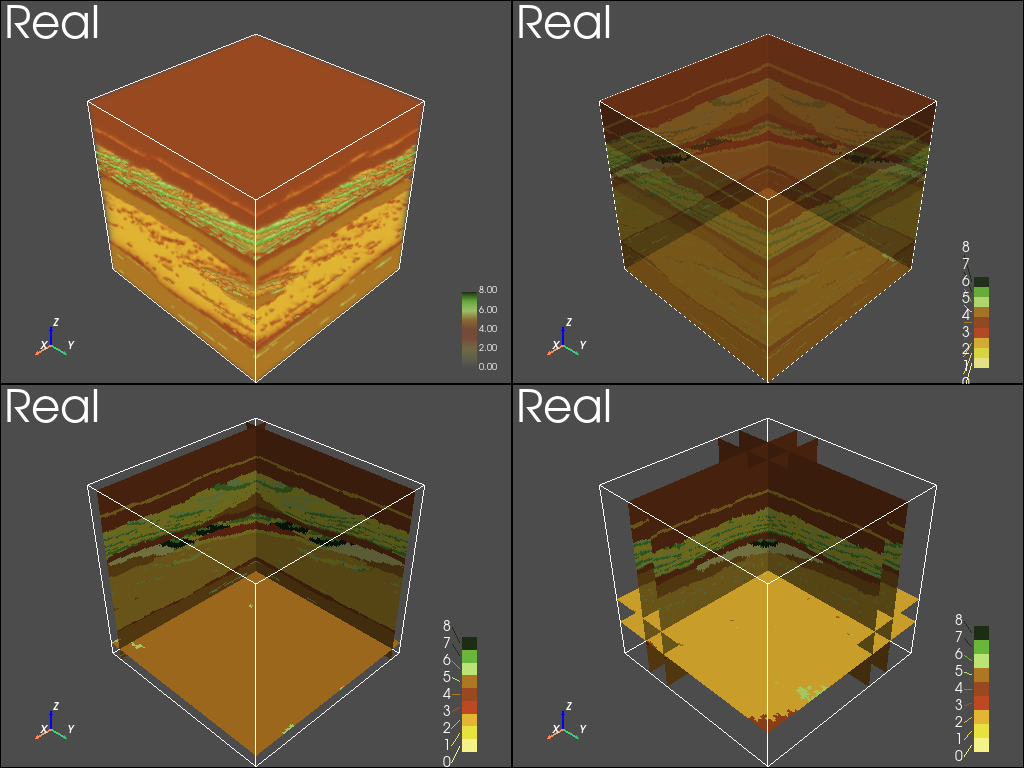

In [15]:
# Retrieve results
sim = deesseX_output['sim']

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

pp.subplot(0,0)
cmap = gn.customcolors.custom_cmap(categCol)
gn.imgplot3d.drawImage3D_volume(sim[0], iv=1, plotter=pp,
    cmin=categVal[0],
    cmax=categVal[-1],
    cmap=cmap,
    scalar_bar_kwargs={'title':' ', 'vertical':True}, # distinct title in each subplot 
                                                      #    for correct display!
    text='Real')

pp.subplot(0,1)
gn.imgplot3d.drawImage3D_surface(sim[0], iv=1, plotter=pp,
    categ=True,
    categVal=categVal,
    categCol=categCol,
    alpha=.9, # transparency (alpha channel)
    scalar_bar_kwargs={'title':'  ', 'vertical':True}, # distinct title in each subplot 
                                                       #    for correct display!
    text='Real')

pp.subplot(1,0)
gn.imgplot3d.drawImage3D_slice(sim[0], iv=1, plotter=pp,
    slice_normal_x=[10], 
    slice_normal_y=[10],
    slice_normal_z=[10],
    categ=True,
    categVal=categVal,
    categCol=categCol,
    alpha=1.0, # transparency (alpha channel)
    scalar_bar_kwargs={'title':'   ', 'vertical':True}, # distinct title in each subplot 
                                                        #    for correct display!
    text='Real')

pp.subplot(1,1)
gn.imgplot3d.drawImage3D_slice(sim[0], iv=1, plotter=pp,
    slice_normal_x=[30, 50], 
    slice_normal_y=[30, 50],
    slice_normal_z=[30, 50],
    categ=True,
    categVal=categVal,
    categCol=categCol,
    alpha=1.0, # transparency (alpha channel)
    scalar_bar_kwargs={'title':'    ', 'vertical':True}, # distinct title in each subplot 
                                                         #    for correct display!
    text='Real')

pp.link_views()
pp.show()